<a href="https://colab.research.google.com/github/Jefferson-Luis/Data-Science-com-Python/blob/main/Modulo_5_Regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import dos pacotes

In [64]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV

# configs do pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)



Import dos metadados

In [65]:
metadados = pd.read_excel('metadata.xlsx')

In [66]:
metadados

,Feature,Feature_Type,Description
0,age,numeric,age of a person
1,job,"Categorical,nominal","type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"categorical,nominal","marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"categorical,nominal","('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,"categorical,nominal","has credit in default? ('no','yes','unknown')"
5,housing,"categorical,nominal","has housing loan? ('no','yes','unknown')"
6,loan,"categorical,nominal","has personal loan? ('no','yes','unknown')"
7,contact,"categorical,nominal","contact communication type ('cellular','telephone')"
8,month,"categorical,ordinal","last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec')"
9,dayofweek,"categorical,ordinal","last contact day of the week ('mon','tue','wed','thu','fri')"


Import dos dados

In [67]:
df = pd.read_csv('new_train.csv', sep=',')

In [68]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


Removendo o Y e adaptando a base para um problema regressor

In [69]:
dados = df.drop(columns=['y']).copy()

In [70]:
dados.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent


Feature engineering - criação de nova variável 

In [71]:
dados['difficulty'] = -1 # desconhecido
dados.loc[(dados['poutcome'] == 'success') & (dados['previous'].between(0,4)), 'difficulty'] = 0   # facil e medio
dados.loc[(dados['poutcome'] == 'success') & (dados['previous'].between(5,8)), 'difficulty'] = 1   # dificil e muito dificil
dados.loc[(dados['poutcome'] == 'failure'), 'difficulty' ] = 2  # Impossivel


In [72]:
dados['difficulty'].value_counts()

-1    28416
 2     3429
 0     1088
 1       17
Name: difficulty, dtype: int64

In [73]:
dados.corr()

,age,duration,campaign,pdays,previous,difficulty
age,1.000000,-0.001841,0.003302,-0.032011,0.020670,0.002181
duration,-0.001841,1.000000,-0.075663,-0.047127,0.022538,-0.003248
campaign,0.003302,-0.075663,1.000000,0.053795,-0.079051,-0.078568
pdays,-0.032011,-0.047127,0.053795,1.000000,-0.589601,-0.184078
previous,0.020670,0.022538,-0.079051,-0.589601,1.000000,0.783286
difficulty,0.002181,-0.003248,-0.078568,-0.184078,0.783286,1.000000


In [74]:
dados.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'difficulty'],
      dtype='object')

In [75]:
dados.isnull().sum()

age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
difficulty     0
dtype: int64

In [76]:
dados.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
difficulty      int64
dtype: object

Separar a target do df de treinamento | teste (validação)

In [77]:
explicativas = dados.drop(columns=['age']).copy()

In [78]:
explicativas.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,difficulty
0,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,-1
1,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,2
2,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,-1
3,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,-1
4,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,-1


In [79]:
var_resp = dados['age'].copy()

In [80]:
var_resp.head()

0    49
1    37
2    78
3    36
4    59
Name: age, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


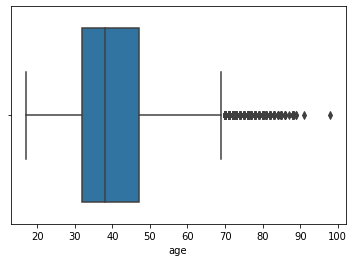

In [81]:
# var_resp.value_counts().hist()   | utilizando histograma

sns.boxplot(var_resp)  #  plotando 

In [82]:
var_resp.value_counts()

31    1551
32    1474
33    1443
35    1417
34    1404
36    1402
30    1365
29    1171
37    1160
38    1139
39    1131
41    1031
40     945
42     915
45     871
43     827
44     826
46     823
28     799
48     775
47     747
50     707
27     675
49     670
52     625
51     601
53     583
26     583
56     562
54     556
55     527
57     521
25     488
58     455
24     381
59     374
60     223
23     181
22     102
21      80
61      61
62      53
20      52
71      45
66      45
64      43
63      41
65      38
70      37
19      37
72      31
73      30
76      29
68      28
80      26
69      25
67      24
18      22
78      20
74      20
77      18
88      17
75      16
82      15
81      14
83      12
79      11
85      11
86       6
84       5
17       3
89       2
87       1
91       1
98       1
Name: age, dtype: int64

Tratamento das variáveis categóricas

In [83]:
metadados

,Feature,Feature_Type,Description
0,age,numeric,age of a person
1,job,"Categorical,nominal","type of job ('admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')"
2,marital,"categorical,nominal","marital status ('divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)"
3,education,"categorical,nominal","('basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')"
4,default,"categorical,nominal","has credit in default? ('no','yes','unknown')"
5,housing,"categorical,nominal","has housing loan? ('no','yes','unknown')"
6,loan,"categorical,nominal","has personal loan? ('no','yes','unknown')"
7,contact,"categorical,nominal","contact communication type ('cellular','telephone')"
8,month,"categorical,ordinal","last contact month of year ('jan', 'feb', 'mar', …, 'nov', 'dec')"
9,dayofweek,"categorical,ordinal","last contact day of the week ('mon','tue','wed','thu','fri')"


In [84]:
explicativas.dtypes

job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
difficulty      int64
dtype: object

In [85]:
expl_cat = explicativas[['job',            
                         'marital',        
                         'education',      
                         'default',        
                         'housing',       
                         'loan',           
                         'contact',        
                         'month',          
                         'day_of_week',    
                         'poutcome']]
      

In [86]:
expl_num = explicativas [['duration',
             'campaign',
             'pdays',
             'previous',
             'difficulty']]

In [87]:
expli_cat_encoding = pd.get_dummies(expl_cat,
                                    prefix_sep='_',
                                    columns=expl_cat.columns,
                                    drop_first=True)

In [88]:
expli_cat_encoding.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


In [89]:
explicativas_tradadas = expl_num.merge(expli_cat_encoding, left_index = True, right_index=True)

In [90]:
explicativas_tradadas.head()

,duration,campaign,pdays,previous,difficulty,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,227,4,999,0,-1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
1,202,2,999,1,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1148,1,999,0,-1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
3,120,2,999,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,368,2,999,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0


Feature Selection

Seleção de var's categoricas

In [91]:
dt = DecisionTreeRegressor(random_state = 42)

In [92]:
tree_selector = SelectFromModel(dt, max_features=5)
tree_selector.fit(expli_cat_encoding, var_resp)
tree_support = tree_selector.get_support()
tree_feature = expli_cat_encoding.loc[:, tree_support].columns.tolist()
tree_feature

['job_retired', 'marital_single', 'default_unknown', 'housing_yes', 'loan_yes']

In [93]:
rf = RandomForestRegressor(random_state=42)

rfe_selector = RFE(estimator=rf,
                   n_features_to_select=2)

rfe_selector.fit(expl_num, var_resp)
rfe_support = rfe_selector.get_support()
rfe_feature = expl_num.loc[:, rfe_support].columns.tolist()
rfe_feature

['duration', 'campaign']

Base a ser considera na modelagem 

In [94]:
expl_num_feature = expl_num[['duration', 'campaign']]

In [95]:
expl_cat.columns


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [96]:
expl_cat_feature_selection = expl_cat[['job','marital','default','housing','loan']].copy()

In [97]:
expl_cat_feature = pd.get_dummies(expl_cat_feature_selection,
                                    prefix_sep='_',
                                    columns=expl_cat_feature_selection.columns,
                                    drop_first=True)


In [98]:
expl_cat_feature.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [99]:
explicativas_modelagem  = expl_num_feature.merge(expl_cat_feature, left_index=True, right_index=True)
explicativas_modelagem.head()

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Quebrar entre train test | treino e teste

In [100]:
x_treino, x_teste, y_treino, y_teste = train_test_split(explicativas_modelagem,
                                                        var_resp,
                                                        test_size=0.3,
                                                        random_state=42)

In [101]:
x_treino.shape

(23065, 22)

In [102]:
x_teste.shape

(9885, 22)

Treinamento dos modelos

In [109]:
tree = DecisionTreeRegressor(random_state=42)

In [110]:
rf = RandomForestRegressor(random_state=42)

In [111]:
gb = GradientBoostingRegressor(random_state=42)

In [132]:
tree_cross_antes_do_greater_is_better = cross_val_score(estimator= tree,
                                                        X=x_treino,
                                                        y=y_treino,
                                                        cv=3,
                                                        scoring=make_scorer(mean_absolute_error))

In [133]:
tree_cross_antes_do_greater_is_better

array([9.2936446 , 9.20231313, 9.22613163])

In [138]:
tree_cross_antes_do_greater_is_better

array([9.2936446 , 9.20231313, 9.22613163])

In [134]:
tree.fit(x_treino, y_treino)

DecisionTreeRegressor(random_state=42)

In [135]:
mean_absolute_error(y_treino, tree.predict(x_treino))

0.8620767396488187

In [136]:
mean_absolute_error(y_teste, tree.predict(x_teste))

9.079376159163715

In [137]:
rf.fit(x_treino, y_treino)

RandomForestRegressor(random_state=42)

In [118]:
gb.fit(x_treino, y_treino)

GradientBoostingRegressor(random_state=42)

In [119]:
mean_absolute_error(y_treino, rf.predict(x_treino))

3.058313480062342

In [120]:
mean_absolute_error(y_teste, rf.predict(x_teste))

7.252896887710165

In [121]:
mean_absolute_error(y_treino, gb.predict(x_treino))

6.57986000531845

In [122]:
mean_absolute_error(y_teste, gb.predict(x_teste))

6.637892323582641

Tuning de hiperparametros

In [123]:
# exemplo com random Forest Regressor 

rf_grid_dict = {
    'n_estimators':[50,100,200],
    'bootstrap':[True, False],
    'random_state':[42]

}

In [127]:
rf_grid = GridSearchCV(rf,
          rf_grid_dict,
          cv=2,
          scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [128]:
rf_grid

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [129]:
rf_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'n_estimators': [50, 100, 200], 'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [139]:
rf_grid.best_params_

{'bootstrap': True, 'n_estimators': 200, 'random_state': 42}

In [140]:
rf_grid.best_score_

-7.2717619720221744

In [141]:
mean_absolute_error(y_teste, rf_grid.predict(x_teste))

7.236136896856586

Fazendo o tuning com o modelo do GradientBoostingRegressor

In [142]:
gb = GradientBoostingRegressor(random_state=42)

In [143]:
gb_grid_dict = {
    'max_depth':[1,3,8],
    'n_estimators':[10,20],
    'random_state':[42]
}

In [149]:
gb_grid = GridSearchCV(gb,
                       gb_grid_dict,
                       scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                       cv=2,
                       n_jobs=2)

In [150]:
gb_grid.fit(x_treino, y_treino)

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [151]:
gb_grid.best_params_

{'max_depth': 8, 'n_estimators': 20, 'random_state': 42}

In [152]:
gb_grid.best_score_

-6.751334227515821

Metricas

In [153]:
mean_squared_error(y_treino, gb_grid.predict(x_treino), squared=True)

63.677772810835435

In [154]:
mean_squared_error(y_teste, gb_grid.predict(x_teste), squared=True)

68.68349148754422

Serializar o modelo

Fazendo a escrita dos objetos treinados no hard disk

In [157]:
# salvando os modelos 

import pickle 
import joblib

In [158]:
with open('gb_pickle.pkl','wb') as modelo:
  pickle.dump(gb_grid, modelo)

In [160]:
joblib.dump(gb_grid,'gb_joblib.pkl')

['gb_joblib.pkl']

Fazendo a leitura dos modelos serializados

In [161]:
modelo_no_pickle = pickle.load(open('gb_pickle.pkl','rb'))

In [162]:
modelo_no_pickle

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [163]:
gb_grid

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

In [164]:
modelo_no_joblib = joblib.load('gb_joblib.pkl')

In [165]:
modelo_no_joblib

GridSearchCV(cv=2, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'max_depth': [1, 3, 8], 'n_estimators': [10, 20],
                         'random_state': [42]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False))

Prevendo os valores usando o modelo

In [166]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


In [168]:
explicativas_modelagem.head()

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [171]:
teste_predicao = explicativas_modelagem.iloc[0,:]

In [172]:
teste_predicao

duration             227
campaign               4
job_blue-collar        1
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_married        1
marital_single         0
marital_unknown        0
default_unknown        1
default_yes            0
housing_unknown        0
housing_yes            0
loan_unknown           0
loan_yes               0
Name: 0, dtype: int64

In [177]:
teste_predicao = explicativas_modelagem.iloc[[0]]

In [179]:
teste_predicao

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [178]:
modelo_no_joblib.predict(teste_predicao)

array([42.45162562])

In [180]:
mean_absolute_error([49], [42.86])

6.140000000000001

In [181]:
teste_predicao = explicativas_modelagem.iloc[:5,:]

In [182]:
teste_predicao

,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes
0,227,4,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,202,2,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1148,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,120,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,368,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [192]:
resultado_teste = modelo_no_joblib.predict(teste_predicao)
resultado_teste

array([42.45162562, 40.64432024, 62.15552057, 40.08563763, 66.02690592])

In [188]:
teste_predicao_target = df.iloc[:5,0]
teste_predicao_target

0    49
1    37
2    78
3    36
4    59
Name: age, dtype: int64

In [191]:
mean_absolute_error(teste_predicao_target, resultado_teste)

7.429943516749001